In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math

import os
import sys
from numpy.fft import fft, ifft
import glob

## Funções Auxiliares

In [2]:
def remove_periodic(X, df_index, detrending=True, frequency_threshold=0.1e12):
    rad = np.array(X)
    
    if detrending:
        det_rad = rad - np.average(rad)
    else:
        det_rad = rad
    
    det_rad_fft = fft(det_rad)

    # Get the power spectrum
    rad_ps = [np.abs(rd)**2 for rd in det_rad_fft]
    
    clean_rad_fft = [det_rad_fft[i] if rad_ps[i] > frequency_threshold else 0 
                     for i in range(len(det_rad_fft))]
    
    rad_series_clean = ifft(clean_rad_fft)
    rad_series_clean = [value.real for value in rad_series_clean]
    
    if detrending:
        rad_trends = rad_series_clean + np.average(rad)
    
    rad_clean_ts = pd.Series(rad_trends, index=df_index)
    
    #rad_clean_ts[(rad_clean_ts.index.hour < 6) | (rad_clean_ts.index.hour > 20)] = 0
    
    return rad - rad_clean_ts.values, rad_clean_ts.values

In [3]:
def normalized_rmse(targets, forecasts):
    if isinstance(targets, list):
        targets = np.array(targets)
    if isinstance(forecasts, list):
        forecasts = np.array(forecasts)
    return ((np.sqrt(np.nanmean((targets - forecasts) ** 2))) / np.nanmean(targets) ) * 100


In [4]:
def load_data(path, resampling=None):
    ## some resampling options: 'H' - hourly, '15min' - 15 minutes, 'M' - montlhy
    ## more options at:
    ## http://benalexkeen.com/resampling-time-series-data-with-pandas/
    allFiles = glob.iglob(path + "/**/*.txt", recursive=True)
    frame = pd.DataFrame()
    list_ = []
    for file_ in allFiles:
        #print("Reading: ",file_)
        df = pd.read_csv(file_,index_col="Tm",parse_dates=['Tm'], header=0, sep="\t")
        if frame.columns is None :
            frame.columns = df.columns
        list_.append(df)
    frame = pd.concat(list_)
    if resampling is not None:
        frame = frame.resample(resampling).mean()
    return frame

In [5]:
def pearson_correlation_coef(x1, x2, nlags):

    lags = np.arange(0,nlags)
    pearson = []
    std = np.std(x1) * np.std(x2)

    for lag in lags:
        cv = np.cov(x1[lag:], x2[0:(len(x2)-lag)])
        pearson.append(cv[0,1] / std)
    
    return pearson

In [6]:
def splt_train_test(df, train_percent):

    from random import shuffle

    ind = pd.DataFrame({"dayofyear": df.index.dayofyear, "year": df.index.year})
    ind = ind.groupby(['dayofyear','year'], as_index=False).first()

    length = len(ind)
    train_size = int(train_percent * length)
    test_size = int((1 - train_percent) * length)

    indexes = np.arange(0,length)
    shuffle(indexes)

    train_ind = indexes[0:train_size]
    test_ind = indexes[train_size:]


    train_df = pd.DataFrame(columns=df.columns)
    test_df = pd.DataFrame(columns=df.columns)

    for i in train_ind:
        d = df[(df.index.dayofyear == ind.iloc[i].dayofyear) & (df.index.year == ind.iloc[i].year)]
        train_df = train_df.append(d)
    
    for i in test_ind:
        d = df[(df.index.dayofyear == ind.iloc[i].dayofyear) & (df.index.year == ind.iloc[i].year)]
        test_df = test_df.append(d)
        
    return train_df, test_df

NameError: name 'shuffle' is not defined

In [ ]:
train_ind = indexes[0:train_size-1]
test_ind = indexes[train_size:]


df = s716_df
train_df = pd.DataFrame(columns=df.columns)

for i in train_ind:
    d = df[(df1.index.dayofyear == ind[i].dayofyear) & (df1.index.year == ind[i].year)]
    train_df.append(d)


## Base SINGA

In [8]:
#Mac
singa_path = '/Users/cseveriano/spatio-temporal-forecasting/data/raw/SINGA-Nobre/'

#Windows
#singa_path = 'C:\\Users\\cseve\\Google Drive\\Doutorado\\Codes\\spatio-temporal-forecasting\\data\\raw\\SINGA-Nobre\\'

s716_df = load_data(singa_path+"716", '15min')
s716_df = s716_df.fillna(method='ffill')

s717_df = load_data(singa_path+"717", '15min')
s717_df = s717_df.fillna(method='ffill')

In [12]:
s716_df[0:96]['AvgGsi00']

Tm
2017-11-01 00:00:00     -0.050267
2017-11-01 00:15:00     -0.109400
2017-11-01 00:30:00     -0.073467
2017-11-01 00:45:00     -0.115533
2017-11-01 01:00:00     -0.105933
2017-11-01 01:15:00     -0.133933
2017-11-01 01:30:00     -0.118067
2017-11-01 01:45:00     -0.210667
2017-11-01 02:00:00     -0.145933
2017-11-01 02:15:00     -0.080933
2017-11-01 02:30:00     -0.081933
2017-11-01 02:45:00     -0.128067
2017-11-01 03:00:00     -0.139533
2017-11-01 03:15:00     -0.096467
2017-11-01 03:30:00     -0.081867
2017-11-01 03:45:00     -0.050600
2017-11-01 04:00:00     -0.104200
2017-11-01 04:15:00     -0.114867
2017-11-01 04:30:00     -0.045400
2017-11-01 04:45:00     -0.154933
2017-11-01 05:00:00     -0.134846
2017-11-01 05:15:00     -0.142200
2017-11-01 05:30:00     -0.057000
2017-11-01 05:45:00     -0.092667
2017-11-01 06:00:00     -0.051867
2017-11-01 06:15:00     -0.111133
2017-11-01 06:30:00     -0.042867
2017-11-01 06:45:00      4.305267
2017-11-01 07:00:00     21.139133
2017-11-01 

In [14]:
s716_df = s716_df[(s716_df.index.hour >= 7) & (s716_df.index.hour <= 18)]
s717_df = s717_df[(s717_df.index.hour >= 7) & (s717_df.index.hour <= 18)]


In [15]:
s716_residual, s716_clean = remove_periodic(s716_df['AvgGsi00'],s716_df.index, frequency_threshold=0.01e11)
s717_residual, s717_clean = remove_periodic(s717_df['AvgGsi00'],s717_df.index, frequency_threshold=0.01e11)

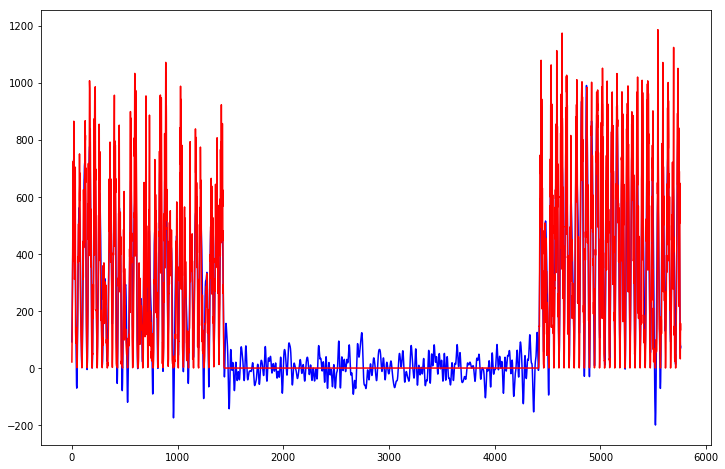

In [18]:
fig = plt.figure(figsize=(12, 8))
plt.plot(s716_clean, color='blue')
plt.plot(s716_df.AvgGsi00.values, color='red')
plt.show()

In [ ]:
s716_df = pd.DataFrame(data={'AvgGsi00': s716_df.AvgGsi00.tolist(), 'residual': s716_residual, 'clean': s716_clean, 'date' : s716_df.index}, index=s716_df.index)
s717_df = pd.DataFrame(data={'AvgGsi00': s717_df.AvgGsi00.tolist(), 'residual': s717_residual, 'clean': s717_clean, 'date' : s717_df.index}, index=s717_df.index)

In [ ]:
s716_train_df, s716_test_df = splt_train_test(s716_df, 0.8)
s717_train_df, s717_test_df = splt_train_test(s717_df, 0.8)

In [ ]:
pearson_correlation_coef(s716_df.clean.tolist(),s717_df.clean.tolist(), 48)

In [ ]:
pearson_716_717

In [ ]:
s717_df.index.year

In [ ]:
pearson_717_716

## Vector Autoregressive (VAR)

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, DynamicVAR

In [ ]:
train_var_df = pd.DataFrame(data={'s716_res': s716_train_df.residual.tolist(), 's717_res': s717_train_df.residual.tolist()}, index=s716_train_df.index)
test_var_df = pd.DataFrame(data={'s716_res': s716_test_df.residual.tolist(), 's717_res': s717_test_df.residual.tolist()}, index=s716_test_df.index)

In [ ]:
model = VAR(train_var_df)
results = model.fit(maxlags=6, ic='aic')

In [ ]:
order = results.k_ar
forecast = []
for i in range(len(test_df)-order) :
    forecast.append(results.forecast(test_var_df.values[i:i+order],1))

In [ ]:
fcst = [item[0][0] for item in forecast]
obs = s716_test_df[order:].AvgGsi00.tolist()
fcst =  [sum(x) for x in zip(fcst, s716_test_df[order:].clean.tolist())]

In [ ]:
_nrmse = normalized_rmse(obs, fcst)
print("nRMSE: ", _nrmse, "\n")

## High Order FTS

In [ ]:
from pyFTS.models.multivariate import common, variable, mvfts
from pyFTS.models.seasonal import partitioner as seasonal
from pyFTS.models.seasonal.common import DateTime
from pyFTS.partitioners import Grid, Util as pUtil
from pyFTS.models.multivariate import common, variable, mvfts
from pyFTS.models import hofts

In [ ]:

train = s716_train_df.residual

fuzzy_sets = Grid.GridPartitioner(data=train, npart=100)
model_hofts = hofts.HighOrderFTS("FTS", partitioner=fuzzy_sets)
model_hofts.fit(train, order=6)

In [ ]:
forecast_hofts = model_hofts.predict(s716_test_df.residual)
forecasted_final = forecast_hofts + s716_test_df[5:].clean

In [ ]:
_nrmse = normalized_rmse(s716_test_df.AvgGsi00.tolist()[5:], forecasted_final)
print("nRMSE: ", _nrmse, "\n")

In [ ]:
fig, ax = plt.subplots(figsize=[20,5])

test = s716_test_df[125:150]
fcst = forecasted_final[120:145]
ax.plot(test['date'].values, test['AvgGsi00'].values)
ax.plot(test['date'].values, fcst)

In [ ]:
forecasted_final[95:145]